In [49]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import glob

import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
import json

import subprocess
from sklearn.metrics import f1_score

from scipy.stats import spearmanr
from scipy.stats import kendalltau

# Search Engine Evaluation

In [50]:
def generate_random_ranking(N: int):
    ranked_list = list(range(N))
    random.shuffle(ranked_list)
    relevant_list = [1 if random.random() < 0.5 else 0 for _ in range(N)]
    return ranked_list, relevant_list

def run_experiments(num_experiments: int, num_iterations: int, N=0):
    experiment_data = []
    for _ in range(num_experiments):
        ranked_lists = []
        relevant_lists = []
        if N <= 0:
            N = random.randint(5, 20)
        # N is fixed for an experiment
        for _ in range(num_iterations):
            ranked_list, relevant_list = generate_random_ranking(N)
            ranked_lists.append(ranked_list)
            relevant_lists.append(relevant_list)
        experiment_data.append((N, ranked_lists, relevant_lists))
    return experiment_data

In [51]:
experiment_data = run_experiments(1, 100)

## Task 1

In [52]:
def precision_recall(ranked_list: list, relevant_list: list, rank=0):
    num_relevant = sum(relevant_list)
    num_retrieved = 0
    num_relevant_and_retrieved = 0
    precision = []
    recall = []
    for i in range(len(ranked_list)):
        num_retrieved += 1
        if relevant_list[ranked_list[i]] == 1:
            num_relevant_and_retrieved += 1
        precision.append(num_relevant_and_retrieved / num_retrieved)
        recall.append(num_relevant_and_retrieved / num_relevant)
    if rank > 0 and rank <= len(ranked_list):
        return precision[rank-1], recall[rank-1]
    return precision, recall

### Complete precison-recall

In [53]:
# Example to get entire precision and recall from a ranking in a single experiment
N, ranked_lists, relevant_lists = experiment_data[0]

idx = 0
ranked_list, relevant_list = ranked_lists[idx], relevant_lists[idx]
precision, recall = precision_recall(ranked_list, relevant_list)
print(f"Ranked List:\n{ranked_list}")
print(f"Relevant List:\n{relevant_list}")
print(f"\nPrecision:\n{precision}")
print(f"Recall:\n{recall}")

Ranked List:
[1, 5, 11, 6, 13, 8, 2, 0, 4, 12, 3, 10, 7, 9]
Relevant List:
[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]

Precision:
[1.0, 0.5, 0.3333333333333333, 0.5, 0.4, 0.5, 0.5714285714285714, 0.5, 0.4444444444444444, 0.4, 0.45454545454545453, 0.4166666666666667, 0.46153846153846156, 0.5]
Recall:
[0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.2857142857142857, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 1.0]


### Precision and Recall @ Rank

In [54]:
# Example to get precision and recall at a particular rank from a ranking in a single experiment
N, ranked_lists, relevant_lists = experiment_data[0]

idx = 0
rank = 5
ranked_list, relevant_list = ranked_lists[idx], relevant_lists[idx]
precision, recall = precision_recall(ranked_list, relevant_list, rank=rank)
print(f"Ranked List:\n{ranked_list}")
print(f"Relevant List:\n{relevant_list}")
print(f"\nPrecision@{rank}: {precision}")
print(f"Recall@{rank}: {recall}")

Ranked List:
[1, 5, 11, 6, 13, 8, 2, 0, 4, 12, 3, 10, 7, 9]
Relevant List:
[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]

Precision@5: 0.4
Recall@5: 0.2857142857142857


## Task 2

### Random rankings P-R curve

In [55]:
# Plot the P-R curves for 2 ranking lists in a single experiment. Each experiment contains multiple ranking lists and each ranking list corresponds to 1 query.
N, ranked_lists, relevant_lists = experiment_data[0]

# Select first random ranking list from the experiment
rand_idx = random.randint(0, len(ranked_lists)-1)
ranked_list, relevant_list = ranked_lists[rand_idx], relevant_lists[rand_idx]
precision, recall = precision_recall(ranked_list, relevant_list)
print("Trial 1")
print(f"Ranked List:\n{ranked_list}")
print(f"Relevant List:\n{relevant_list}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Select second random ranking list from the experiment
rand_idx2 = random.randint(0, len(ranked_lists)-1)
while rand_idx2 == rand_idx:
    rand_idx2 = random.randint(0, len(ranked_lists)-1)
ranked_list2, relevant_list2 = ranked_lists[rand_idx2], relevant_lists[rand_idx2]
precision2, recall2 = precision_recall(ranked_list2, relevant_list2)
print("\nTrial 2")
print(f"Ranked List:\n{ranked_list2}")
print(f"Relevant List:\n{relevant_list2}")
print(f"\nPrecision: {precision2}")
print(f"Recall: {recall2}")

Trial 1
Ranked List:
[12, 13, 5, 4, 1, 7, 0, 9, 11, 2, 8, 10, 6, 3]
Relevant List:
[1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1]
Precision: [0.0, 0.5, 0.3333333333333333, 0.5, 0.4, 0.5, 0.5714285714285714, 0.5, 0.4444444444444444, 0.4, 0.45454545454545453, 0.4166666666666667, 0.46153846153846156, 0.5]
Recall: [0.0, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.2857142857142857, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 1.0]

Trial 2
Ranked List:
[10, 11, 7, 5, 3, 12, 0, 4, 1, 8, 9, 6, 2, 13]
Relevant List:
[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1]

Precision: [0.0, 0.0, 0.3333333333333333, 0.25, 0.2, 0.3333333333333333, 0.2857142857142857, 0.25, 0.2222222222222222, 0.3, 0.2727272727272727, 0.3333333333333333, 0.3076923076923077, 0.35714285714285715]
Recall: [0.0, 0.0, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 0.4, 0.6, 0.6, 0.8, 0.8, 1.0]


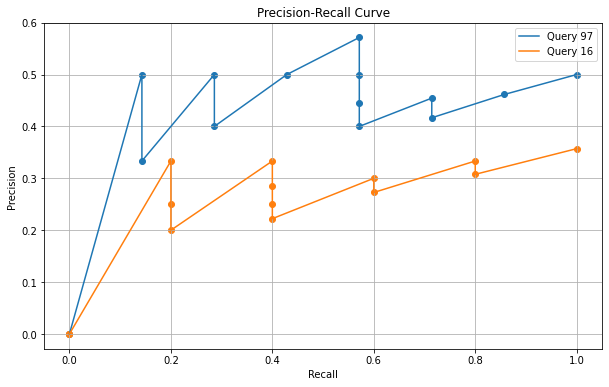

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f"Query {rand_idx}")
plt.scatter(recall, precision)
plt.plot(recall2, precision2, label=f"Query {rand_idx2}")
plt.scatter(recall2, precision2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

### Rankings for BM25

In [57]:
def remove_characters(text: str) -> str:
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def get_text_files(path: str, N=0, shuffle=False) -> list:
    text_files = glob.glob(f"{path}/*.txt")
    if shuffle:
        random.shuffle(text_files)
    if N > 0:
        text_files = text_files[:N]
    return text_files

def get_text(text_files: list) -> list:
    text = []
    for text_file in text_files:
        with open(text_file, 'r', errors='ignore') as f:
            content = remove_characters(f.read())
            content = content.lower()
            text.append(content)
    return text

def tokenization(text):
    if type(text) == list:
        return [word_tokenize(t) for t in text]
    elif type(text) == str:
        return word_tokenize(text)
    return None

def stemmer(tokenized_text: list):
    ps = PorterStemmer()
    stemmed_text = []
    for doc in tokenized_text:
        stemmed_text.append([ps.stem(token) for token in doc])

    stemmed_dict = {}
    for doc in stemmed_text:
        for token in doc:
            if token in stemmed_dict:
                stemmed_dict[token] += 1
            else:
                stemmed_dict[token] = 1
    
    return stemmed_dict, stemmed_text

In [58]:
def get_terms_per_doc(tokenized_text: list):
    terms_per_doc = [set(doc) for doc in tokenized_text]
    return terms_per_doc

def get_terms(tokenized_text: list):
    terms = set()
    for doc in tokenized_text:
        for token in doc:
            terms.add(token)
    return list(terms)

# Term Frequency
def get_tf_dict(tokenized_text: list, text_file_names: list, stemming=False):
    tf = {}
    if stemming:
        ps = PorterStemmer()
        for i, doc in enumerate(tokenized_text):
            freq_dict = {}
            for token in doc:
                root = ps.stem(token)
                if root in freq_dict:
                    freq_dict[root] += 1
                else:
                    freq_dict[root] = 1
            file = text_file_names[i]
            tf[file] = freq_dict
    else:
        for i, doc in enumerate(tokenized_text):
            freq_dict = {}
            for token in doc:
                if token in freq_dict:
                    freq_dict[token] += 1
                else:
                    freq_dict[token] = 1
            file = text_file_names[i]
            tf[file] = freq_dict
    return tf

# Inverse Document Frequency
def get_idf_dict(tokenized_text: list, text_file_names: list, stemming=False):
    if stemming:
        _, tokenized_text = stemmer(tokenized_text)
    terms_per_doc = get_terms_per_doc(tokenized_text)
    terms = get_terms(tokenized_text)
    idf = {}
    N = len(text_file_names)
    for term in terms:
        count = 0
        for doc in terms_per_doc:
            if term in doc:
                count += 1
        idf[term] = np.log2(N / count)
    return idf

# BM25
def get_BM25_matrix(tokenized_text: list, text_files: list, stemming=False, k=1.75, b=0.75):
    tf_dict = get_tf_dict(tokenized_text, text_files, stemming=stemming)
    idf_dict = get_idf_dict(tokenized_text, text_files, stemming=stemming)
    docLengths = [len(doc) for doc in tokenized_text]
    avgDocLength = np.mean(docLengths)
    bm25_matrix = pd.DataFrame.from_dict(tf_dict)
    bm25_matrix = bm25_matrix.fillna(0)
    terms = bm25_matrix.index.values.tolist()
    docs = bm25_matrix.columns.values.tolist()
    for i, doc in enumerate(docs):
        bm25_matrix[doc] = bm25_matrix[doc] * (k + 1) / (bm25_matrix[doc] + k * (1 - b + b * docLengths[i] / avgDocLength))
    for term in terms:
        bm25_matrix.loc[term] = bm25_matrix.loc[term] * idf_dict[term]
    return bm25_matrix

def generate_ranking(df: pd.DataFrame, query: str):
    if query not in df.index:
        return None
    return df.loc[query].sort_values(ascending=False)

In [59]:
# Generate bm25 matrix
directory = "./nasa"
text_files = get_text_files(directory, shuffle=False)
text_file_names = [text_file.split('/')[-1] for text_file in text_files]
text = get_text(text_files)
tokenized_text = tokenization(text)
bm25_matrix = get_BM25_matrix(tokenized_text, text_file_names, stemming=False)

queries = ["engine", "analysis"]

#### Query 1: "engine"

In [60]:
# Generate ranking for first query
query = queries[0]
ranking = generate_ranking(bm25_matrix, query)
print(f"Query: {query}")
print(f"Ranking:\n{ranking}")

Query: engine
Ranking:
sbr18995.txt     7.585623
inf17195.txt     6.802372
ins18795.txt     5.777557
sbr17695.txt     5.469030
sbr21495.txt     5.070059
                   ...   
ins04095.txt     0.000000
mat02095.txt     0.000000
inf14495.txt     0.000000
sbr191b95.txt    0.000000
ins16295.txt     0.000000
Name: engine, Length: 141, dtype: float64


In [61]:
# Get relevant documents from .key files
cmd = f"grep -rlE '\\b{query}\\b' {directory}/*.key"
output = !{cmd}
relevant_docs = output.grep(".*")
relevant_docs = [doc.split("/")[-1].split(".")[0] + ".txt" for doc in relevant_docs]
print(f"Relevant documents:\n{relevant_docs}")

Relevant documents:
['sbr18995.txt', 'sbr21495.txt']


In [62]:
# Calculate precision and recall for first query
ranked_list1 = [text_file_names.index(doc) for doc in ranking.index.values.tolist()]
relevant_list1 = [1 if text_file_name in relevant_docs else 0 for text_file_name in text_file_names]
precision, recall = precision_recall(ranked_list1, relevant_list1)
print(f"Ranked List:\n{ranked_list1}")
print(f"Relevant List:\n{relevant_list1}")
print(f"Text files in order:\n{text_file_names}")
print(f"\nPrecision: {precision}")
print(f"Recall: {recall}")

Ranked List:
[85, 16, 28, 4, 40, 44, 34, 26, 131, 119, 88, 60, 117, 95, 55, 2, 114, 96, 102, 97, 101, 98, 103, 99, 100, 104, 0, 94, 93, 105, 91, 90, 89, 87, 86, 84, 83, 82, 81, 80, 79, 78, 92, 110, 106, 125, 139, 138, 137, 136, 135, 134, 133, 132, 130, 129, 128, 127, 126, 124, 107, 123, 122, 121, 120, 118, 116, 115, 113, 112, 111, 76, 109, 108, 77, 70, 75, 38, 36, 35, 33, 32, 31, 30, 29, 27, 25, 24, 23, 22, 21, 20, 19, 18, 17, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 3, 37, 39, 74, 41, 73, 72, 71, 1, 69, 68, 67, 66, 65, 64, 63, 62, 61, 59, 58, 57, 56, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 43, 42, 140]
Relevant List:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

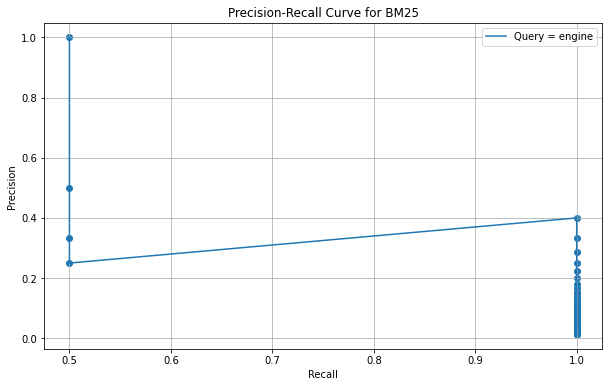

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f"Query = {query}")
plt.scatter(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for BM25")
plt.legend()
plt.grid()
plt.show()

#### Query 2: "analysis"

In [64]:
# Generate ranking for second query
query = queries[1]
ranking = generate_ranking(bm25_matrix, query)
print(f"Query: {query}")
print(f"Ranking:\n{ranking}")

Query: analysis
Ranking:
sbr15695.txt     4.276000
emt01995.txt     4.159888
sbr17995.txt     4.110909
emt04795.txt     3.980607
emt04895.txt     3.934655
                   ...   
mat02095.txt     0.000000
str03295.txt     0.000000
inf14495.txt     0.000000
sbr191b95.txt    0.000000
ins16295.txt     0.000000
Name: analysis, Length: 141, dtype: float64


In [65]:
# Get relevant documents from .key files
cmd = f"grep -rlE '\\b{query}\\b' {directory}/*.key"
output = !{cmd}
relevant_docs = output.grep(".*")
relevant_docs = [doc.split("/")[-1].split(".")[0] + ".txt" for doc in relevant_docs]
print(f"Relevant documents:\n{relevant_docs}")

Relevant documents:
['emt01995.txt', 'emt04895.txt', 'emt04995.txt', 'emt05095.txt', 'emt05995.txt', 'emt10395.txt', 'emt10695.txt', 'emt13495.txt', 'emt15895.txt', 'eos16995.txt', 'inf19695.txt', 'inf21695.txt', 'mip14195.txt', 'sbr15695.txt', 'sbr17995.txt', 'sbr18995.txt', 'str10095.txt']


In [66]:
# Calculate precision and recall for second query
ranked_list2 = [text_file_names.index(doc) for doc in ranking.index.values.tolist()]
relevant_list2 = [1 if text_file_name in relevant_docs else 0 for text_file_name in text_file_names]
precision, recall = precision_recall(ranked_list2, relevant_list2)
print(f"Ranked List:\n{ranked_list2}")
print(f"Relevant List:\n{relevant_list2}")
print(f"Text files in order:\n{text_file_names}")
print(f"\nPrecision: {precision}")
print(f"Recall: {recall}")

Ranked List:
[113, 103, 109, 24, 133, 139, 56, 83, 112, 82, 104, 105, 33, 128, 1, 73, 60, 2, 86, 129, 85, 72, 4, 67, 136, 39, 94, 90, 84, 91, 131, 58, 19, 30, 97, 116, 51, 101, 21, 74, 32, 95, 96, 93, 92, 88, 98, 87, 99, 89, 0, 100, 102, 138, 137, 135, 134, 132, 130, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 115, 114, 111, 80, 110, 108, 107, 106, 81, 70, 79, 38, 36, 35, 34, 31, 29, 28, 27, 26, 25, 23, 22, 20, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 3, 37, 40, 78, 41, 77, 76, 75, 71, 69, 68, 66, 65, 64, 63, 62, 61, 59, 57, 55, 54, 53, 52, 50, 49, 48, 47, 46, 45, 44, 43, 42, 140]
Relevant List:
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

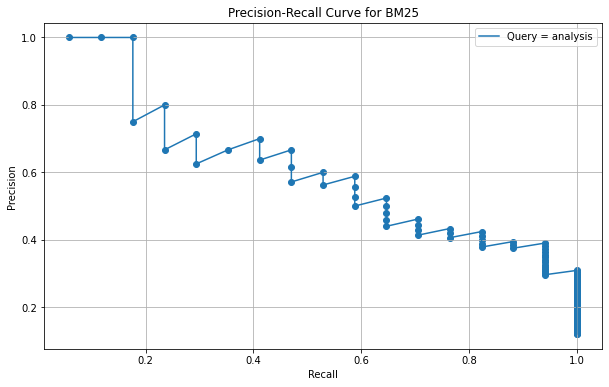

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f"Query = {query}")
plt.scatter(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for BM25")
plt.legend()
plt.grid()
plt.show()

## Task 3

In [68]:
def nDCG(ranked_list: list, relevant_list: list, rank=0):
    gains = []
    for i in range(len(ranked_list)):
        if relevant_list[ranked_list[i]] == 1:
            gains.append(1 / np.log2(i + 2))
        else:
            gains.append(0)
    dcg = [gains[0]]
    for i in range(1, len(gains)):
        dcg.append(dcg[i-1] + gains[i])
    print(f"DCG: {dcg}")

    ideal_ranked_list = sorted(range(len(relevant_list)), key=lambda k: relevant_list[k], reverse=True)
    ideal_gains = []
    for i in range(len(ideal_ranked_list)):
        if relevant_list[ideal_ranked_list[i]] == 1:
            ideal_gains.append(1 / np.log2(i + 2))
        else:
            ideal_gains.append(0)
    ideal_dcg = [ideal_gains[0]]
    for i in range(1, len(ideal_gains)):
        ideal_dcg.append(ideal_dcg[i-1] + ideal_gains[i])
    print(f"Ideal DCG: {ideal_dcg}")
    
    ndcg = [dcg[i]/ideal_dcg[i] for i in range(len(dcg))]
    if rank > 0 and rank <= len(ranked_list):
        return ndcg[rank-1]
    return ndcg

### Random rankings for nDCG

In [69]:
# Compute nDCG for a ranking in a single experiment
N, ranked_lists, relevant_lists = experiment_data[0]
print(f"Ranked List:\n{ranked_list}")
print(f"Relevant List:\n{relevant_list}")
print(f"Text files in order:\n{text_file_names}\n")

ndcg = nDCG(ranked_lists[0], relevant_lists[0])
print(f"nDCG: {ndcg}")

Ranked List:
[12, 13, 5, 4, 1, 7, 0, 9, 11, 2, 8, 10, 6, 3]
Relevant List:
[1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1]
Text files in order:
['ins15795.txt', 'emt15895.txt', 'ins20495.txt', 'inf12795.txt', 'sbr17695.txt', 'ins04195.txt', 'emt10195.txt', 'emt20895.txt', 'sbr16395.txt', 'mip14895.txt', 'emt13295.txt', 'ins13995.txt', 'sbr21395.txt', 'str07995.txt', 'ins07495.txt', 'inf02895.txt', 'inf17195.txt', 'sbr12295.txt', 'ins19295.txt', 'str10095.txt', 'sbr12195.txt', 'inf07395.txt', 'str05695.txt', 'eos21295.txt', 'emt04795.txt', 'ins07595.txt', 'eos19895.txt', 'mip15495.txt', 'ins18795.txt', 'str12695.txt', 'ins20595.txt', 'emt14295.txt', 'mip14195.txt', 'emt10495.txt', 'eos00395.txt', 'ins03495.txt', 'mip01195.txt', 'str10895.txt', 'inf144b95.txt', 'inf19695.txt', 'sbr21495.txt', 'ins09595.txt', 'sbr191b95.txt', 'inf14495.txt', 'str03295.txt', 'mat02095.txt', 'ins04095.txt', 'eos19995.txt', 'mat18195.txt', 'inf12495.txt', 'emt17495.txt', 'ins05895.txt', 'inf11595.txt', 'mat06395.

### Rankings for BM25

#### Query 1: "engine"

In [70]:
# Calculate nDCG for query1
query = queries[0]
print(f"Ranked List:\n{ranked_list1}")
print(f"Relevant List:\n{relevant_list1}")
print(f"Text files in order:\n{text_file_names}\n")

ndcg = nDCG(ranked_list1, relevant_list1)
print(f"nDCG: {ndcg}")

Ranked List:
[85, 16, 28, 4, 40, 44, 34, 26, 131, 119, 88, 60, 117, 95, 55, 2, 114, 96, 102, 97, 101, 98, 103, 99, 100, 104, 0, 94, 93, 105, 91, 90, 89, 87, 86, 84, 83, 82, 81, 80, 79, 78, 92, 110, 106, 125, 139, 138, 137, 136, 135, 134, 133, 132, 130, 129, 128, 127, 126, 124, 107, 123, 122, 121, 120, 118, 116, 115, 113, 112, 111, 76, 109, 108, 77, 70, 75, 38, 36, 35, 33, 32, 31, 30, 29, 27, 25, 24, 23, 22, 21, 20, 19, 18, 17, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 3, 37, 39, 74, 41, 73, 72, 71, 1, 69, 68, 67, 66, 65, 64, 63, 62, 61, 59, 58, 57, 56, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 43, 42, 140]
Relevant List:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

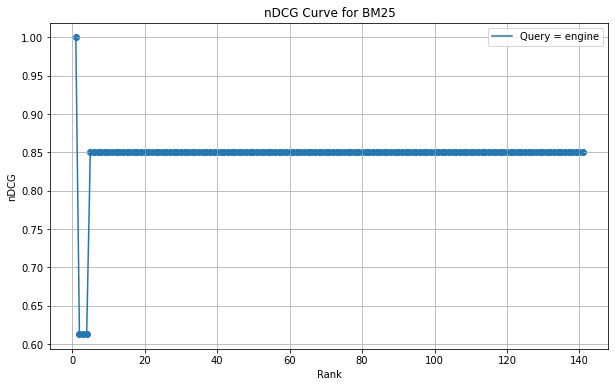

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(ndcg)+1), ndcg, label=f"Query = {query}")
plt.scatter(range(1, len(ndcg)+1), ndcg)
plt.xlabel("Rank")
plt.ylabel("nDCG")
plt.title("nDCG Curve for BM25")
plt.legend()
plt.grid()
plt.show()

#### Query 2: "analysis"

In [72]:
# Calculate nDCG for query2
query = queries[1]
print(f"Ranked List:\n{ranked_list2}")
print(f"Relevant List:\n{relevant_list2}")
print(f"Text files in order:\n{text_file_names}\n")

ndcg = nDCG(ranked_list2, relevant_list2)
print(f"nDCG: {ndcg}")

Ranked List:
[113, 103, 109, 24, 133, 139, 56, 83, 112, 82, 104, 105, 33, 128, 1, 73, 60, 2, 86, 129, 85, 72, 4, 67, 136, 39, 94, 90, 84, 91, 131, 58, 19, 30, 97, 116, 51, 101, 21, 74, 32, 95, 96, 93, 92, 88, 98, 87, 99, 89, 0, 100, 102, 138, 137, 135, 134, 132, 130, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 115, 114, 111, 80, 110, 108, 107, 106, 81, 70, 79, 38, 36, 35, 34, 31, 29, 28, 27, 26, 25, 23, 22, 20, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 3, 37, 40, 78, 41, 77, 76, 75, 71, 69, 68, 66, 65, 64, 63, 62, 61, 59, 57, 55, 54, 53, 52, 50, 49, 48, 47, 46, 45, 44, 43, 42, 140]
Relevant List:
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

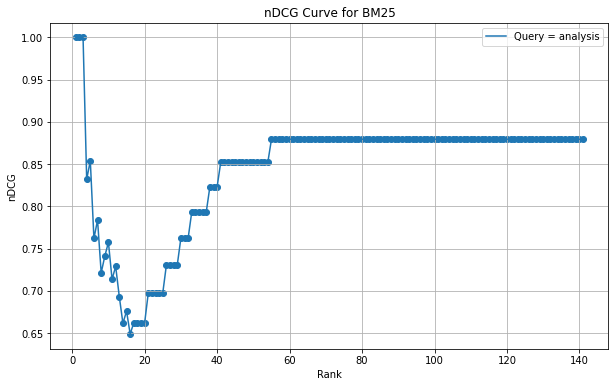

In [73]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(ndcg)+1), ndcg, label=f"Query = {query}")
plt.scatter(range(1, len(ndcg)+1), ndcg)
plt.xlabel("Rank")
plt.ylabel("nDCG")
plt.title("nDCG Curve for BM25")
plt.legend()
plt.grid()
plt.show()

## Task 4

#### Query 1: "engine"

In [74]:
query = queries[0]
precision, recall = precision_recall(ranked_list1, relevant_list1)
print(f"Ranked List:\n{ranked_list1}")
print(f"Relevant List:\n{relevant_list1}")
print(f"Text files in order:\n{text_file_names}")
print(f"\nPrecision: {precision}")
print(f"Recall: {recall}")

# Average Precision till recall at 1
avg_precision1 = np.mean(precision[:np.argmax(recall)+1])
print(f"\nAverage Precision: {avg_precision1}")

Ranked List:
[85, 16, 28, 4, 40, 44, 34, 26, 131, 119, 88, 60, 117, 95, 55, 2, 114, 96, 102, 97, 101, 98, 103, 99, 100, 104, 0, 94, 93, 105, 91, 90, 89, 87, 86, 84, 83, 82, 81, 80, 79, 78, 92, 110, 106, 125, 139, 138, 137, 136, 135, 134, 133, 132, 130, 129, 128, 127, 126, 124, 107, 123, 122, 121, 120, 118, 116, 115, 113, 112, 111, 76, 109, 108, 77, 70, 75, 38, 36, 35, 33, 32, 31, 30, 29, 27, 25, 24, 23, 22, 21, 20, 19, 18, 17, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 3, 37, 39, 74, 41, 73, 72, 71, 1, 69, 68, 67, 66, 65, 64, 63, 62, 61, 59, 58, 57, 56, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 43, 42, 140]
Relevant List:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

#### Query 2: "analysis"

In [75]:
query = queries[1]
precision, recall = precision_recall(ranked_list2, relevant_list2)
print(f"Ranked List:\n{ranked_list2}")
print(f"Relevant List:\n{relevant_list2}")
print(f"Text files in order:\n{text_file_names}")
print(f"\nPrecision: {precision}")
print(f"Recall: {recall}")

# Average Precision till recall at 1
avg_precision2 = np.mean(precision[:np.argmax(recall)+1])
print(f"\nAverage Precision: {avg_precision2}")

Ranked List:
[113, 103, 109, 24, 133, 139, 56, 83, 112, 82, 104, 105, 33, 128, 1, 73, 60, 2, 86, 129, 85, 72, 4, 67, 136, 39, 94, 90, 84, 91, 131, 58, 19, 30, 97, 116, 51, 101, 21, 74, 32, 95, 96, 93, 92, 88, 98, 87, 99, 89, 0, 100, 102, 138, 137, 135, 134, 132, 130, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 115, 114, 111, 80, 110, 108, 107, 106, 81, 70, 79, 38, 36, 35, 34, 31, 29, 28, 27, 26, 25, 23, 22, 20, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 3, 37, 40, 78, 41, 77, 76, 75, 71, 69, 68, 66, 65, 64, 63, 62, 61, 59, 57, 55, 54, 53, 52, 50, 49, 48, 47, 46, 45, 44, 43, 42, 140]
Relevant List:
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [76]:
print(f"Mean Average Precision: {np.mean([avg_precision1, avg_precision2])}")

Mean Average Precision: 0.49714854900145167


## Task 5

In [77]:
def f1_PR(precision: list, recall: list):
    f1 = []
    for i in range(len(precision)):
        if precision[i] + recall[i] == 0:
            f1.append(0)
        else:
            f1.append((precision[i] * recall[i]) / ((precision[i]) + recall[i]))
        if recall[i] == 1:
            break
    return f1

def f1_MM(ranked_list: list, relevant_list: list):
    ranked_relevant_list = [relevant_list[i] for i in ranked_list]

    # Find the last position of 1 in ranked_relevant list
    last_pos_rel = len(ranked_relevant_list) - list(reversed(ranked_relevant_list)).index(1)

    # Compute micro F1 score
    tp = np.sum(ranked_relevant_list)
    fp = len(ranked_relevant_list) - tp
    fn = np.sum(relevant_list) - tp

    # micro_precision = tp / (tp + fp)
    micro_precision = tp / last_pos_rel
    micro_recall = tp / (tp + fn)

    micro_f1_score = (2 * micro_precision * micro_recall) / (micro_precision + micro_recall)

    # Compute macro F1 score
    # For relevant documents
    macro_precision_rel, macro_recall_rel = precision_recall(ranked_list, relevant_list)

    # Change all 0s to 1s and vice versa in ranked_relevant_list
    for i in range(len(ranked_relevant_list)):
        ranked_relevant_list[i] = 1 - ranked_relevant_list[i]

    # For non relevant documents
    macro_precision_not_rel, macro_recall_not_rel = precision_recall(ranked_list, relevant_list)

    macro_f1_scores_rel = f1_PR(macro_precision_rel, macro_recall_rel)
    macro_f1_scores_not_rel = f1_PR(macro_precision_not_rel, macro_recall_not_rel)

    macro_f1_score_rel = np.mean(macro_f1_scores_rel)
    macro_f1_score_not_rel = np.mean(macro_f1_scores_not_rel)

    return micro_f1_score, (macro_f1_score_rel + macro_f1_score_not_rel) / 2

### Example

In [78]:
ranked_list = [3, 6, 2, 4, 7, 9, 0, 1, 5, 8]
relevant_list = [1, 0, 1, 1, 1, 1, 0, 0, 0, 0]

micro_f1_score, macro_f1_score = f1_MM(ranked_list, relevant_list)

print(f"Micro F1 Score: {micro_f1_score}")
print(f"Macro F1 Score: {macro_f1_score}")

Micro F1 Score: 0.7142857142857143
Macro F1 Score: 0.27375032375032377


#### Query 1: "engine"

In [79]:
query = queries[0]
precision, recall = precision_recall(ranked_list1, relevant_list1)
f1 = f1_PR(precision, recall)
print(f"Ranked List:\n{ranked_list1}")
print(f"Relevant List:\n{relevant_list1}")
print(f"Text files in order:\n{text_file_names}")
print(f"\nPrecision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Average Precision till recall at 1
avg_precision1 = np.mean(precision[:np.argmax(recall)+1])
print(f"\nAverage Precision: {avg_precision1}")

# Average F1 Score till recall at 1
avg_f1 = np.mean(f1[:np.argmax(recall)+1])
print(f"\nAverage F1 Score: {avg_f1}")

Ranked List:
[85, 16, 28, 4, 40, 44, 34, 26, 131, 119, 88, 60, 117, 95, 55, 2, 114, 96, 102, 97, 101, 98, 103, 99, 100, 104, 0, 94, 93, 105, 91, 90, 89, 87, 86, 84, 83, 82, 81, 80, 79, 78, 92, 110, 106, 125, 139, 138, 137, 136, 135, 134, 133, 132, 130, 129, 128, 127, 126, 124, 107, 123, 122, 121, 120, 118, 116, 115, 113, 112, 111, 76, 109, 108, 77, 70, 75, 38, 36, 35, 33, 32, 31, 30, 29, 27, 25, 24, 23, 22, 21, 20, 19, 18, 17, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 3, 37, 39, 74, 41, 73, 72, 71, 1, 69, 68, 67, 66, 65, 64, 63, 62, 61, 59, 58, 57, 56, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 43, 42, 140]
Relevant List:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [80]:
micro_f1_score, macro_f1_score = f1_MM(ranked_list1, relevant_list1)

print(f"Micro F1 Score: {micro_f1_score}")
print(f"Macro F1 Score: {macro_f1_score}")

Micro F1 Score: 0.5714285714285715
Macro F1 Score: 0.2471428571428571


#### Query 2: "analysis"

In [81]:
query = queries[1]
precision, recall = precision_recall(ranked_list2, relevant_list2)
f1 = f1_PR(precision, recall)
print(f"Ranked List:\n{ranked_list2}")
print(f"Relevant List:\n{relevant_list2}")
print(f"Text files in order:\n{text_file_names}")
print(f"\nPrecision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Average Precision till recall at 1
avg_precision2 = np.mean(precision[:np.argmax(recall)+1])
print(f"\nAverage Precision: {avg_precision2}")

# Average F1 Score till recall at 1
avg_f1 = np.mean(f1[:np.argmax(recall)+1])
print(f"\nAverage F1 Score: {avg_f1}")

Ranked List:
[113, 103, 109, 24, 133, 139, 56, 83, 112, 82, 104, 105, 33, 128, 1, 73, 60, 2, 86, 129, 85, 72, 4, 67, 136, 39, 94, 90, 84, 91, 131, 58, 19, 30, 97, 116, 51, 101, 21, 74, 32, 95, 96, 93, 92, 88, 98, 87, 99, 89, 0, 100, 102, 138, 137, 135, 134, 132, 130, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 115, 114, 111, 80, 110, 108, 107, 106, 81, 70, 79, 38, 36, 35, 34, 31, 29, 28, 27, 26, 25, 23, 22, 20, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 3, 37, 40, 78, 41, 77, 76, 75, 71, 69, 68, 66, 65, 64, 63, 62, 61, 59, 57, 55, 54, 53, 52, 50, 49, 48, 47, 46, 45, 44, 43, 42, 140]
Relevant List:
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [82]:
micro_f1_score, macro_f1_score = f1_MM(ranked_list2, relevant_list2)

print(f"Micro F1 Score: {micro_f1_score}")
print(f"Macro F1 Score: {macro_f1_score}")

Micro F1 Score: 0.4722222222222222
Macro F1 Score: 0.24695533263805167


## Task 6

In [83]:
def spearman_correlation(ranked_list, relevance_list):
    ordered_relevance_list = [relevance_list[i] for i in ranked_list]
    correlation, _ = spearmanr(ranked_list, ordered_relevance_list)
    return correlation

def kendall_tau_correlation(ranked_list, relevance_list):
    ordered_relevance_list = [relevance_list[i] for i in ranked_list]
    correlation, _ = kendalltau(ranked_list, ordered_relevance_list)
    return correlation

### Query 1: "engine"

In [84]:
query = queries[0]
print(f"Ranked List:\n{ranked_list1}")
print(f"Relevant List:\n{relevant_list1}")
print(f"Text files in order:\n{text_file_names}")
print(f"\nSpearman Correlation: {spearman_correlation(ranked_list1, relevant_list1)}")
print(f"Kendall Tau Correlation: {kendall_tau_correlation(ranked_list1, relevant_list1)}")

Ranked List:
[85, 16, 28, 4, 40, 44, 34, 26, 131, 119, 88, 60, 117, 95, 55, 2, 114, 96, 102, 97, 101, 98, 103, 99, 100, 104, 0, 94, 93, 105, 91, 90, 89, 87, 86, 84, 83, 82, 81, 80, 79, 78, 92, 110, 106, 125, 139, 138, 137, 136, 135, 134, 133, 132, 130, 129, 128, 127, 126, 124, 107, 123, 122, 121, 120, 118, 116, 115, 113, 112, 111, 76, 109, 108, 77, 70, 75, 38, 36, 35, 33, 32, 31, 30, 29, 27, 25, 24, 23, 22, 21, 20, 19, 18, 17, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 3, 37, 39, 74, 41, 73, 72, 71, 1, 69, 68, 67, 66, 65, 64, 63, 62, 61, 59, 58, 57, 56, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 43, 42, 140]
Relevant List:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Query 2: "analysis"

In [85]:
query = queries[1]
print(f"Ranked List:\n{ranked_list2}")
print(f"Relevant List:\n{relevant_list2}")
print(f"Text files in order:\n{text_file_names}")
print(f"\nSpearman Correlation: {spearman_correlation(ranked_list2, relevant_list2)}")
print(f"Kendall Tau Correlation: {kendall_tau_correlation(ranked_list2, relevant_list2)}")

Ranked List:
[113, 103, 109, 24, 133, 139, 56, 83, 112, 82, 104, 105, 33, 128, 1, 73, 60, 2, 86, 129, 85, 72, 4, 67, 136, 39, 94, 90, 84, 91, 131, 58, 19, 30, 97, 116, 51, 101, 21, 74, 32, 95, 96, 93, 92, 88, 98, 87, 99, 89, 0, 100, 102, 138, 137, 135, 134, 132, 130, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 115, 114, 111, 80, 110, 108, 107, 106, 81, 70, 79, 38, 36, 35, 34, 31, 29, 28, 27, 26, 25, 23, 22, 20, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 3, 37, 40, 78, 41, 77, 76, 75, 71, 69, 68, 66, 65, 64, 63, 62, 61, 59, 57, 55, 54, 53, 52, 50, 49, 48, 47, 46, 45, 44, 43, 42, 140]
Relevant List:
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# Zipf's Law

### Identify all unique words

In [86]:
french_book = "./lhomme_qui_rit.txt"
with open(french_book, 'r', errors='ignore') as f:
    french_text = f.read()

# Tokenize the text using regular expressions
words = re.findall(r'\b\w+\b', french_text, flags=re.UNICODE)
words_lower = [word.lower() for word in words]

# Convert to lowercase and create a set to get unique words
unique_words = list(set(words_lower))
print(f"Unique words: {unique_words}")
print(f"Number of unique words: {len(unique_words)}")

Unique words: ['habillées', 'colonne', 'spratt', '1867', 'sauteriaux', 'distinct', 'strictly', 'myope', 'correcte', 'impendendum_', 'ressorts', 'rapprochassent', 'intervention', 'héroïque', 'gerbes', 'entendre', 'morsures', 'dotation', 'spectacle', 'lugubre', 'disproportions', 'soubresaut', 'plaça', 'appliqués', 'chanceliers', 'dénonceraient', 'durerait', 'torsions', 'seigneuries', 'désarroi', 'somnambulisme', 'absorbés', 'performances', 'barreau', 'chien', 'occulte', 'approcha', 'versants', 'bouée', 'payaient', 'convenu', 'déchiquetait', 'chez', 'étendit', 'précipice', 'nommé', 'schellings', 'accablant', 'propriétaire', 'croquelihou', 'schiboleth', 'colonnes', 'parentes', 'section', 'inattendus', 'fêlez', 'promontorium', 'réunie', 'pêcheur', 'mauvaise', 'attachaient', 'pressentait', 'pareille', 'appartenu', 'keepers', 'insecte', 'vitrage', 'infidèle', 'fabrique', 'couperons', 'difficulté', 'frénétique', 'châtierai', 'connais', 'assaillante', 'peregrine', 'procédure', 'chatte', 'citait

### Get document frequency and sort

In [87]:
doc_freq = {}
for word in unique_words:
    doc_freq[word] = words_lower.count(word)

# Sort the dictionary by descending order of frequency
sorted_doc_freq = {k: v for k, v in sorted(doc_freq.items(), key=lambda item: item[1], reverse=True)}
print("Top 10 words with highest frequency:")
for i, (k, v) in enumerate(sorted_doc_freq.items()):
    if i == 10:
        break
    print(f"{k}: {v}")

ranked_words_by_freq = list(sorted_doc_freq.keys())

Top 10 words with highest frequency:
de: 8764
la: 6267
le: 5448
et: 5223
l: 4761
il: 4009
à: 3489
un: 3187
les: 3172
d: 2716


In [88]:
k = 50
df = pd.DataFrame.from_dict(sorted_doc_freq, orient='index', columns=['Frequency'])
df.index.name = 'Word'
df.head(k)

,Frequency
Word,
de,8764
la,6267
le,5448
et,5223
l,4761
il,4009
à,3489
un,3187
les,3172


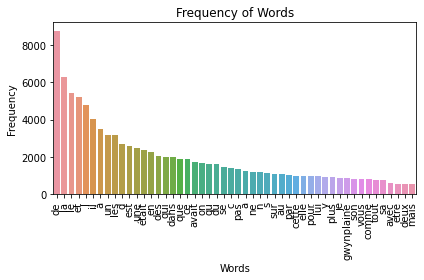

In [89]:
sns.barplot(x=df.index[:k], y=df['Frequency'][:k])
plt.xticks(rotation=90)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Frequency of Words")
plt.tight_layout()
plt.show()

### Transform frequencies into probabilities

In [90]:
n = len(words_lower)

# Divide by document length to get probability of each word
sorted_doc_freq_prob = {k: v/n for k, v in sorted_doc_freq.items()}

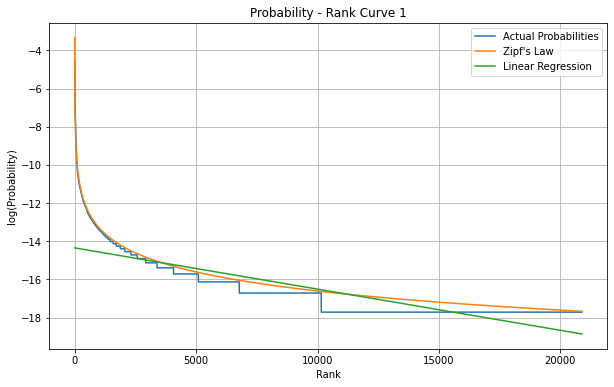

In [91]:
# Take log2 of the probabilities for better visualization
probabilities = np.log2(np.array(list(sorted_doc_freq_prob.values())))
ranks = list(range(1, len(probabilities)+1))

# Zipf's Law
x = np.linspace(1, len(probabilities), len(probabilities))
y = np.log2(np.array([0.1/r for r in x]))

plt.figure(figsize=(10, 6))
plt.plot(ranks, probabilities, label="Actual Probabilities")
plt.plot(x, y, label="Zipf's Law")

# plot the linear regression line
plt.plot(np.unique(ranks), np.poly1d(np.polyfit(ranks, probabilities, 1))(np.unique(ranks)), label="Linear Regression")

plt.xlabel("Rank")
plt.ylabel("log(Probability)")
plt.title("Probability - Rank Curve 1")
plt.legend()
plt.grid()
plt.show()

R-squared: 0.691603148282479
p: -0.00021589244842264092


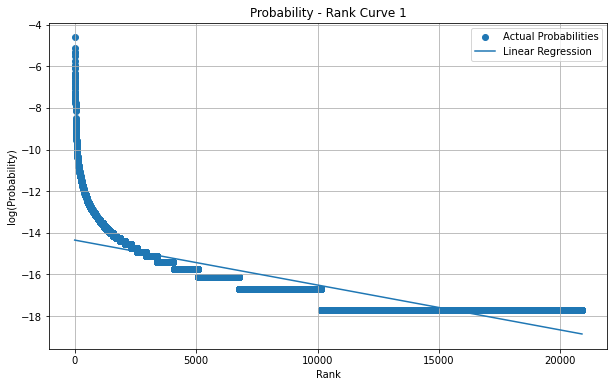

In [92]:
plt.figure(figsize=(10, 6))
plt.scatter(ranks, probabilities, label="Actual Probabilities")

# plot the linear regression line
plt.plot(np.unique(ranks), np.poly1d(np.polyfit(ranks, probabilities, 1))(np.unique(ranks)), label="Linear Regression")
# print the values of R-squared and p for the linear regression line
print(f"R-squared: {np.corrcoef(ranks, probabilities)[0,1] ** 2}")
print(f"p: {np.polyfit(ranks, probabilities, 1)[0]}")

plt.xlabel("Rank")
plt.ylabel("log(Probability)")
plt.title("Probability - Rank Curve 1")
plt.legend()
plt.grid()
plt.show()

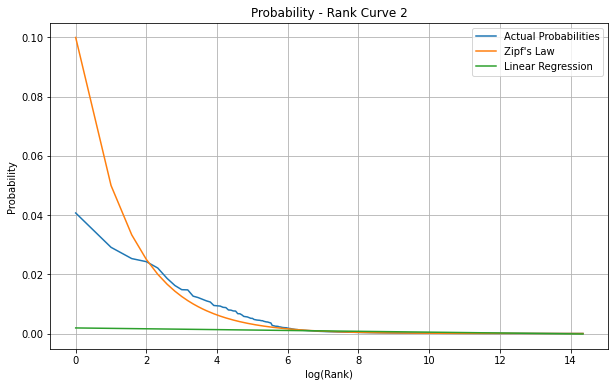

In [93]:
# Take log2 of the ranks to compare with log2 of probabilities
probabilities = np.array(list(sorted_doc_freq_prob.values()))
ranks = np.log2(np.array(list(range(1, len(probabilities)+1))))

# Zipf's Law
x = np.linspace(1, len(probabilities), len(probabilities))
y = np.array([0.1/r for r in x])
x = np.log2(x)

plt.figure(figsize=(10, 6))
plt.plot(ranks, probabilities, label="Actual Probabilities")
plt.plot(x, y, label="Zipf's Law")

# plot the linear regression line
plt.plot(np.unique(ranks), np.poly1d(np.polyfit(ranks, probabilities, 1))(np.unique(ranks)), label="Linear Regression")

plt.xlabel("log(Rank)")
plt.ylabel("Probability")
plt.title("Probability - Rank Curve 2")
plt.legend()
plt.grid()
plt.show()

R-squared: 0.11905528373451266
p: -0.00014196646681273207


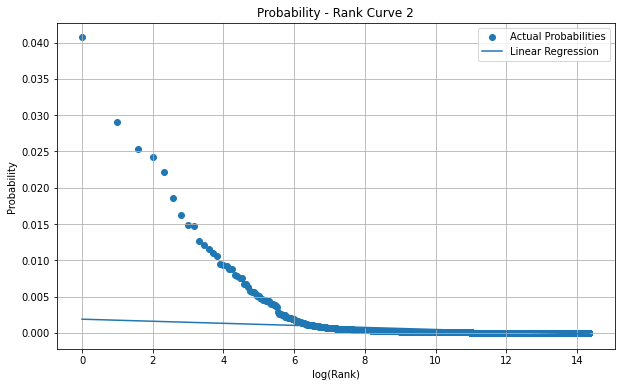

In [94]:
plt.figure(figsize=(10, 6))
plt.scatter(ranks, probabilities, label="Actual Probabilities")

# plot the linear regression line
plt.plot(np.unique(ranks), np.poly1d(np.polyfit(ranks, probabilities, 1))(np.unique(ranks)), label="Linear Regression")
# print the values of R-squared and p for the linear regression line
print(f"R-squared: {np.corrcoef(ranks, probabilities)[0,1] ** 2}")
print(f"p: {np.polyfit(ranks, probabilities, 1)[0]}")

plt.xlabel("log(Rank)")
plt.ylabel("Probability")
plt.title("Probability - Rank Curve 2")
plt.legend()
plt.grid()
plt.show()

From the above 2 probability - rank curves, it is clear that the Zipf's law curve seems to approximate the actual probabilities at each rank, with good accuracy for a majority of the curve. The linear regression model does a better job of fitting the 2nd curve than the first. This is most likely due to the fact that the first curve follows Zipf's law well, since probability (and log(probability)) are inversely proportional to rank, and the second curve is more evened out compared to the first, since we are plotting the log of rank on the x-axis.

### Word categories

In [95]:
df = pd.DataFrame(columns=['Very Frequent Words', 'Averagely Frequent Words', 'Median Frequent Words', 'Very Rare Words'])
items = list(sorted_doc_freq.items())

print("Very Frequent Words:")
col = []
for i in range(10):
    print(f"{items[i][0]}: {items[i][1]}")
    col.append(items[i][0])
df['Very Frequent Words'] = col

avg_freq = np.mean([items[i][1] for i in range(len(items))])
print(f"\nAverage Frequency: {avg_freq}")
start = -1
end = -1
for i in range(len(items)):
    if items[i][1] <= avg_freq:
        start = i
        break
end = start
while end < len(items) and items[end][1] == avg_freq:
    end += 1
idx = (start + end) // 2
print("Averagely Frequent Words:")
col = []
for i in range(idx - 5, idx + 5):
    print(f"{items[i][0]}: {items[i][1]}")
    col.append(items[i][0])
df['Averagely Frequent Words'] = col

print("\nMedian Frequent Words:")
col = []
for i in range(len(items)//2 - 5, len(items)//2 + 5):
    print(f"{items[i][0]}: {items[i][1]}")
    col.append(items[i][0])
df['Median Frequent Words'] = col

print("\nVery Rare Words:") 
col = []
for i in range(len(items)-10, len(items)):
    print(f"{items[i][0]}: {items[i][1]}")
    col.append(items[i][0])
df['Very Rare Words'] = col

Very Frequent Words:
de: 8764
la: 6267
le: 5448
et: 5223
l: 4761
il: 4009
à: 3489
un: 3187
les: 3172
d: 2716

Average Frequency: 10.304993058547561
Averagely Frequent Words:
carrosses: 11
défendu: 11
autrui: 11
irlandais: 11
catastrophe: 11
seigneuries: 10
bouée: 10
paul: 10
allez: 10
souffre: 10

Median Frequent Words:
tournât: 1
renouveler: 1
équilibriste: 1
lâchés: 1
suspendait: 1
soupa: 1
foncées: 1
mantes: 1
emboîter: 1
ondoyant: 1

Very Rare Words:
voulions: 1
enivrer: 1
alarme: 1
abaissant: 1
brevet: 1
idolâtrée: 1
épaissie: 1
propriétés: 1
attiédir: 1
élèvera: 1


In [96]:
df

,Very Frequent Words,Averagely Frequent Words,Median Frequent Words,Very Rare Words
0,de,carrosses,tournât,voulions
1,la,défendu,renouveler,enivrer
2,le,autrui,équilibriste,alarme
3,et,irlandais,lâchés,abaissant
4,l,catastrophe,suspendait,brevet
5,il,seigneuries,soupa,idolâtrée
6,à,bouée,foncées,épaissie
7,un,paul,mantes,propriétés
8,les,allez,emboîter,attiédir
9,d,souffre,ondoyant,élèvera


Intuitively, the last category of 'very rare words' would seem to be more useful in information retrieval since these rare words contain more overall information. Also, since they are sparsely located, the location or position of these words could be useful for analysis, like word association or named-entity-recognition tasks. This last category is also likely to have higher tf-idf score, since idf for these words will be high in a large corpus. In smaller corpuses, the very frequent words will have high tf-idf value. 